In [1]:
#Imports 
import sys
import os
import glob
from datetime import datetime

from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
#import cv2

import torch
import torchvision
from torchvision import transforms
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, Sampler

In [2]:
# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print("Current device is set to: ", device)

Current device is set to:  cuda


In [19]:
class RLBenchTransporterDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        # self.episode_folders = [os.listdir(
        #     os.path.join(self.root, 'variation0/episodes/episode{}/front_rgb/'.format(i)))
        #     for i in range(1, num_episodes)]
        pattern = os.path.join(root, "**/episodes/episode*/front_rgb/*.png")
        self.image_files = glob.glob(pattern, recursive=True)
        self.length = len(self.image_files)

    def __len__(self):
        return self.length

    def get_image(self, n):
        image = Image.open(self.image_files[n])
        return image

    def __getitem__(self, idx):
        # Randomly choose a another frame, as all episodes have the same 
        # objects, we can choose anything
        target_index = idx - np.random.randint(1, self.length)

        source_image = Image.open(self.image_files[idx])
        target_image = Image.open(self.image_files[target_index])
        if self.transform is not None:
            source_image = self.transform(source_image)
            target_image = self.transform(target_image)

        return source_image, target_image

        
data_dir = '/home/mustafa/code/graph-imitation-learning/data/reach_target/'

transformer = transforms.Compose([
                                 # transforms.Resize((128, 128)), Already 128
                                 transforms.ToTensor()
                                 ])

dataset = RLBenchTransporterDataset(data_dir, transform=transformer)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, pin_memory=True, num_workers=0)

In [8]:
sys.path.append('../src/transporter/model/')
sys.path.append('../src/transporter/')
from transporter import *

IMAGE_CHANNELS = 3
K = 4

# Build Transporter Model architecture
feature_encoder = FeatureExtractor(IMAGE_CHANNELS)
key_net = KeyNet(IMAGE_CHANNELS, K)
refine_net = RefineNet(IMAGE_CHANNELS)

transporter_model = Transporter(feature_encoder, key_net, refine_net)
transporter_model.to(device=device)

Transporter(
  (feature_extractor): FeatureExtractor(
    (net): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (3): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),

In [13]:
model_dir = '/home/mustafa/code/graph-imitation-learning/success_runs/transporter_reach_target/transporter_model.pth'
checkpoint = torch.load(model_dir)
transporter_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


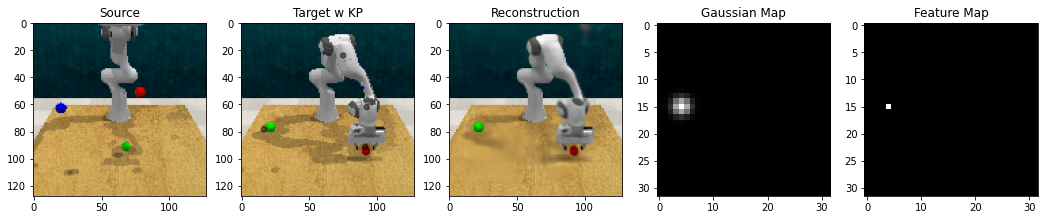

In [40]:
from matplotlib.patches import Circle

def get_random_color(pastel_factor=0.5):
    return [(x + pastel_factor) / (1.0 + pastel_factor)
            for x in [np.random.uniform(0, 1.0) for i in [1, 2, 3]]]


def color_distance(c1, c2):
    return sum([abs(x[0] - x[1]) for x in zip(c1, c2)])


def generate_new_color(existing_colors, pastel_factor=0.5):
    max_distance = None
    best_color = None
    for i in range(0, 100):
        color = get_random_color(pastel_factor=pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color, c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color


def get_n_colors(n, pastel_factor=0.9):
    colors = []
    for i in range(n):
        colors.append(generate_new_color(colors, pastel_factor=0.9))
    return colors

black_color = [0., 0., 0.]

with torch.no_grad():
    transporter_model.eval()
    
    for image, target in loader:
        break
        
    image = image.to(device=device)
    target = target.to(device=device)
    
    keypoints = transporter_model.key_net(image)
    reconstruction = transporter_model(image, target)
    
    fig, ax = plt.subplots(1, 5, figsize=(18, 5))
    idx = 0
    k_idx = 1
    std = 0.1

    feature_maps = spatial_softmax(keypoints)
    gmap = gaussian_map(feature_maps, std)[idx, k_idx]
    
    ax[0].set_title('Source')
    ax[0].imshow(np.transpose(image[idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    
    ax[1].set_title('Target w KP')
    ax[1].imshow(np.transpose(target[idx].cpu().numpy(), (1, 2, 0)))
    
    ax[2].set_title('Reconstruction')
    ax[2].imshow(np.transpose(reconstruction[idx].cpu().numpy(), (1, 2, 0)))
    
    ax[3].set_title('Gaussian Map')
    ax[3].imshow(gmap.cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
    
    ax[4].set_title('Feature Map')
    ax[4].imshow(feature_maps[idx, k_idx].cpu().numpy(), cmap='gray')

    normalized_left_locs = compute_keypoint_location_mean(spatial_softmax(transporter_model.key_net(target)))[idx]
    left_locs = (normalized_left_locs + 1) / 2 * 128
    colors = get_n_colors(len(left_locs))
    for i, l in enumerate(left_locs):
        ax[1].add_patch(Circle((l[1].item(), l[0].item()), 2, 
                               color=black_color, alpha=0.5))

In [27]:
# Visualizing the right image
source_index, target_index = n
right_image = np.array(Image.open('{}{}r.jpg'.format(data_dir, target_index[0])))
right_image = transformer(right_image)
right_image = right_image.unsqueeze(0)
right_image = right_image.to(device=device)

normalized_right_locs = compute_keypoint_location_mean(spatial_softmax(transporter_model.point_net(right_image)))[idx]
right_locs = (normalized_right_locs + 1) / 2 * 128
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].imshow(np.transpose(target[idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
ax[1].imshow(np.transpose(right_image[0].cpu().numpy(), (1, 2, 0)))

for i, l in enumerate(left_locs):
    ax[0].add_patch(Circle((l[1].item(), l[0].item()), 2, color=black_color, alpha=0.5))

for i, l in enumerate(right_locs):
    ax[1].add_patch(Circle((l[1].item(), l[0].item()), 2, color=black_color, alpha=0.5))

NameError: name 'n' is not defined

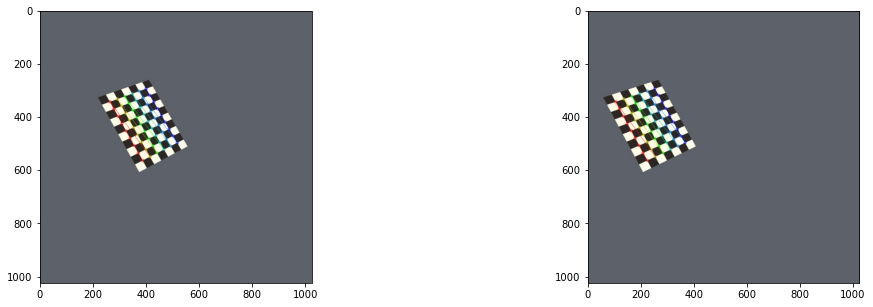

In [29]:
img_l = cv2.imread('C:/code/unity-simulations/data/5ball/feb1/calib/0l.jpg')
img_r = cv2.imread('C:/code/unity-simulations/data/5ball/feb1/calib/0r.jpg')

gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

# Find the chess board corners
ret_l, corners_l = cv2.findChessboardCorners(gray_l, (9, 6), None)
ret_r, corners_r = cv2.findChessboardCorners(gray_r, (9, 6), None)

#print(ret_l, corners_l)
#print(ret_r, corners_r)

# If found, add object points, image points (after refining them)
#self.objpoints.append(self.objp)
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

criteria = (cv2.TERM_CRITERIA_EPS +
                         cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
if ret_l is True:
    rt = cv2.cornerSubPix(gray_l, corners_l, (11, 11), (-1, -1), criteria)
    #self.imgpoints_l.append(corners_l)

    # Draw and display the corners
    ret_l = cv2.drawChessboardCorners(img_l, (9, 6),corners_l, ret_l)
    ax[0].imshow(img_l)

if ret_r is True:
    rt = cv2.cornerSubPix(gray_r, corners_r, (11, 11),
                          (-1, -1), criteria)
    #self.imgpoints_r.append(corners_r)

    # Draw and display the corners
    ret_r = cv2.drawChessboardCorners(img_r, (9, 6),
                                      corners_r, ret_r)
    ax[1].imshow(img_r)
    
    
#img_shape = gray_l.shape[::-1]

#rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(
    #self.objpoints, self.imgpoints_l, img_shape, None, None)
#rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(
    #self.objpoints, self.imgpoints_r, img_shape, None, None)

#self.camera_model = self.stereo_calibrate(img_shape)

In [9]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
# https://github.com/bvnayak/stereo_calibration/blob/master/camera_calibrate.py

class StereoCalibration(object):
    def __init__(self, filepath):
        # termination criteria
        self.criteria = (cv2.TERM_CRITERIA_EPS +
                         cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (cv2.TERM_CRITERIA_EPS +
                             cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((9*6, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = []  # 3d point in real world space
        self.imgpoints_l = []  # 2d points in image plane.
        self.imgpoints_r = []  # 2d points in image plane.

        self.cal_path = filepath
        self.read_images(self.cal_path)

    def read_images(self, cal_path):
        images_right = glob.glob(cal_path + '*r.jpg')
        images_left = glob.glob(cal_path + '*l.jpg')
        print(f"Found {len(images_left)} left camera images")
        print(f"Found {len(images_right)} right camera images")
        images_left.sort()
        images_right.sort()

        for i, fname in enumerate(images_right):
            img_l = cv2.imread(images_left[i])
            img_r = cv2.imread(images_right[i])

            gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret_l, corners_l = cv2.findChessboardCorners(gray_l, (9, 6), None)
            ret_r, corners_r = cv2.findChessboardCorners(gray_r, (9, 6), None)

            # If found, add object points, image points (after refining them)
            self.objpoints.append(self.objp)

            if ret_l is True:
                rt = cv2.cornerSubPix(gray_l, corners_l, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_l.append(corners_l)

                # Draw and display the corners
                ret_l = cv2.drawChessboardCorners(img_l, (9, 6),
                                                  corners_l, ret_l)
                #cv2.imshow(images_left[i], img_l)
                #cv2.waitKey(500)

            if ret_r is True:
                rt = cv2.cornerSubPix(gray_r, corners_r, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_r.append(corners_r)

                # Draw and display the corners
                ret_r = cv2.drawChessboardCorners(img_r, (9, 6),
                                                  corners_r, ret_r)
                #cv2.imshow(images_right[i], img_r)
                #cv2.waitKey(500)
            img_shape = gray_l.shape[::-1]

        rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_l, img_shape, None, None)
        rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_r, img_shape, None, None)

        self.camera_model = self.stereo_calibrate(img_shape)

    def stereo_calibrate(self, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        # flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_ASPECT_RATIO
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        # flags |= cv2.CALIB_RATIONAL_MODEL
        # flags |= cv2.CALIB_SAME_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_K3
        # flags |= cv2.CALIB_FIX_K4
        # flags |= cv2.CALIB_FIX_K5

        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +
                                cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints, self.imgpoints_l,
            self.imgpoints_r, self.M1, self.d1, self.M2,
            self.d2, dims,
            criteria=stereocalib_criteria, flags=flags)

        print('Intrinsic_mtx_1', M1)
        print('dist_1', d1)
        print('Intrinsic_mtx_2', M2)
        print('dist_2', d2)
        print('R', R)
        print('T', T)
        print('E', E)
        print('F', F)

        # for i in range(len(self.r1)):
        #     print("--- pose[", i+1, "] ---")
        #     self.ext1, _ = cv2.Rodrigues(self.r1[i])
        #     self.ext2, _ = cv2.Rodrigues(self.r2[i])
        #     print('Ext1', self.ext1)
        #     print('Ext2', self.ext2)

        print('')

        camera_model = dict([('M1', M1), ('M2', M2), ('dist1', d1),
                            ('dist2', d2), ('rvecs1', self.r1),
                            ('rvecs2', self.r2), ('R', R), ('T', T),
                            ('E', E), ('F', F)])

        cv2.destroyAllWindows()
        return camera_model

In [10]:
cal_data = StereoCalibration('C:/code/unity-simulations/data/5ball/feb1/calib/')
print(cal_data)

Found 40 left camera images
Found 40 right camera images
Intrinsic_mtx_1 [[888.50125916   0.         512.50849058]
 [  0.         888.7273904  510.55432679]
 [  0.           0.           1.        ]]
dist_1 [[-0.00360547  0.01256044 -0.00032629  0.0001738  -0.00881348]]
Intrinsic_mtx_2 [[887.58594769   0.         512.66474712]
 [  0.         887.56754121 511.39835855]
 [  0.           0.           1.        ]]
dist_2 [[ 2.18061086e-03 -1.54331276e-02  9.75313522e-05  3.26766262e-04
   3.87113352e-02]]
R [[ 9.99999959e-01 -1.29619021e-06 -2.86338406e-04]
 [ 9.46426086e-07  9.99999254e-01 -1.22150290e-03]
 [ 2.86339776e-04  1.22150258e-03  9.99999213e-01]]
T [[-4.99718995]
 [ 0.00686324]
 [-0.02814316]]
E [[ 1.99185318e-06  2.81515233e-02  6.82885469e-03]
 [-2.67122654e-02  6.10411689e-03  4.99719407e+00]
 [-6.86796623e-03 -4.99718621e+00  6.10604722e-03]]
F [[ 2.53555412e-08  3.58267113e-04 -1.05691516e-01]
 [-3.40044136e-04  7.76849503e-05  5.66554823e+01]
 [ 9.62863703e-02 -5.66704157

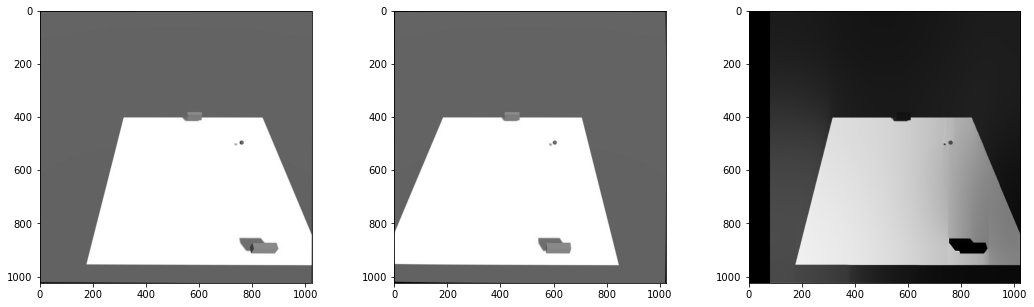

In [11]:
# Check Calibration
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
                cal_data.camera_model["M1"],
                cal_data.camera_model["dist1"],
                cal_data.camera_model["M2"],
                cal_data.camera_model["dist2"],
                (1024, 1024),
                cal_data.camera_model["R"],
                cal_data.camera_model["T"]
            )

width = 1024
height = 1024
K1 = cal_data.camera_model["M1"]
D1 = cal_data.camera_model["dist1"]
K2 = cal_data.camera_model["M2"]
D2 = cal_data.camera_model["dist2"]


def depth_map(imgL, imgR):
    """ Depth map calculation. Works with SGBM and WLS. Need rectified images, returns depth map ( left to right disparity ) """
    # SGBM Parameters -----------------
    window_size = 3  # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely

    left_matcher = cv2.StereoSGBM_create(
        minDisparity=-1,
        numDisparities=5*16,  # max_disp has to be dividable by 16 f. E. HH 192, 256
        blockSize=window_size,
        P1=8 * 3 * window_size,
        # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
        P2=32 * 3 * window_size,
        disp12MaxDiff=12,
        uniquenessRatio=10,
        speckleWindowSize=50,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
    # FILTER Parameters
    lmbda = 80000
    sigma = 1.3
    visual_multiplier = 6

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)

    wls_filter.setSigmaColor(sigma)
    displ = left_matcher.compute(imgL, imgR)  # .astype(np.float32)/16
    dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!

    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    filteredImg = np.uint8(filteredImg)

    return filteredImg

left_frame = cv2.imread('C:/code/unity-simulations/data/pong/feb12/stereo/0l.jpg')
right_frame = cv2.imread('C:/code/unity-simulations/data/pong/feb12/stereo/0r.jpg')

leftMapX, leftMapY = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (width, height), cv2.CV_32FC1)
left_rectified = cv2.remap(left_frame, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
rightMapX, rightMapY = cv2.initUndistortRectifyMap(K2, D2, R2, P2, (width, height), cv2.CV_32FC1)
right_rectified = cv2.remap(right_frame, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

# We need grayscale for disparity map.
gray_left = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)

disparity_image = depth_map(gray_left, gray_right)  # Get the disparity map

fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].imshow(cv2.cvtColor(gray_left, cv2.COLOR_GRAY2RGB))
ax[1].imshow(cv2.cvtColor(gray_right, cv2.COLOR_GRAY2RGB))
ax[2].imshow(cv2.cvtColor(disparity_image, cv2.COLOR_GRAY2RGB))
plt.show()


Triangulating Point 0:
Triangulating Left:[653. 471.] Right X:[515. 472.]
Euclidian Co-ordinate: X:[5.3095994] Y:[-1.4245903] Z:[32.16169]
Ground Truth Depth: 30.98229411764706cm
#############################
Triangulating Point 1:
Triangulating Left:[680. 396.] Right X:[538. 396.]
Euclidian Co-ordinate: X:[6.110219] Y:[-4.041463] Z:[31.255747]
Ground Truth Depth: 32.15864705882353cm
#############################
Triangulating Point 2:
Triangulating Left:[624. 892.] Right X:[404. 892.]
Euclidian Co-ordinate: X:[2.6718352] Y:[8.658001] Z:[20.174164]
Ground Truth Depth: 19.218764705882357cm
#############################


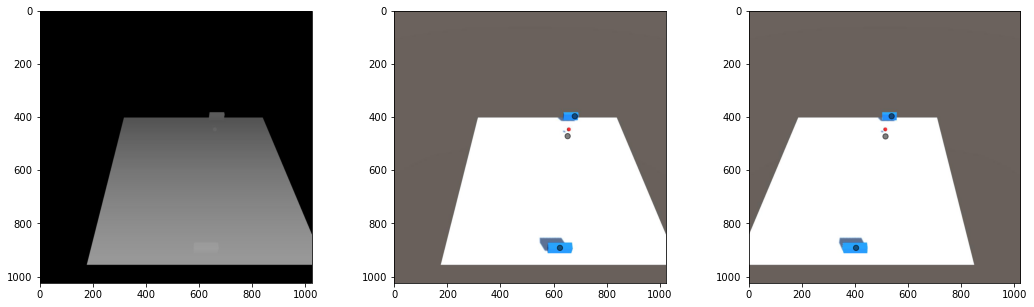

In [12]:
points_left = normalized_left_locs.detach().cpu().numpy()
points_right = normalized_right_locs.detach().cpu().numpy()

points_left = (points_left + 1) / 2 * 1024
points_right = (points_right + 1) / 2 * 1024

points_left = np.around(points_left)
points_right = np.around(points_right)

left_depth_image = np.array(Image.open('{}{}l.jpg'.format(depth_dir, target_index[0])))
left_image = np.array(Image.open('{}{}l.jpg'.format(data_dir, target_index[0])))
right_image = np.array(Image.open('{}{}r.jpg'.format(data_dir, target_index[0])))

for i, l in enumerate(right_locs):
    left_point = np.array([points_left[i][1], points_left[i][0]])
    right_point = np.array([points_right[i][1], points_right[i][0]])
    print(f"Triangulating Point {i}:")
    print(f"Triangulating Left:{left_point} Right X:{right_point}")
    triang_point = cv2.triangulatePoints(P1, P2, left_point, right_point)
    euclidian = triang_point / triang_point[3]
    euclidian = np.asarray(euclidian, dtype=np.float32)
    print(f"Euclidian Co-ordinate: X:{euclidian[0]} Y:{euclidian[1]} Z:{euclidian[2]}")
    
    left_point = left_point.astype(int)
    r = left_depth_image[left_point[1]][left_point[0]][0]
    g = left_depth_image[left_point[1]][left_point[0]][1]
    b = left_depth_image[left_point[1]][left_point[0]][2]
    gray = (0.2989 * r) + (0.5870 * g) + (0.1140 * b)
    
    # Check the depth on the depth map, Use the scaling of depth shader, in our case 0-100cm
    # White would calculate to 100, so we invert it for depth
    depth = 50 - ((gray/255) * 50)
    print(f"Ground Truth Depth: {depth}cm")
    print("#############################")

fig, ax = plt.subplots(1, 3, figsize=(18,5))
# Visualize everything
ax[0].imshow(left_depth_image)
ax[1].imshow(left_image)
ax[2].imshow(right_image)

for i, l in enumerate(points_left):
    ax[1].add_patch(Circle((l[1].item(), l[0].item()), 10, color=black_color, alpha=0.5))

for i, l in enumerate(points_right):
    ax[2].add_patch(Circle((l[1].item(), l[0].item()), 10, color=black_color, alpha=0.5))


In [48]:
# OpenCV Feature Matching Using ORB 

# Computing the Descriptors for known pixel keypoint locations
image = np.transpose(target[0].cpu().numpy(), (1, 2, 0))
cimage = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
cimage = cv2.cvtColor(cimage, cv2.COLOR_RGB2BGR)
resized_image = cv2.resize(cimage, (IMAGE_DIM, IMAGE_DIM))

# Note: Location of keypoints are (y, x)
scaled_locs = (locs.cpu().numpy() + 1) / 2 * IMAGE_DIM
gray = cv2.cvtColor(resized_image,cv2.COLOR_BGR2GRAY)
kp = []
for i in range(0, len(scaled_locs)):
    kp.append(cv2.KeyPoint(scaled_locs[i][1], scaled_locs[i][0], 12, -1, 0, 0, -1))

kp, desc = orb.compute(gray, kp)

# Finding descriptors from second image
source_index, target_index = n
tar_image = cv2.imread(f"{data_dir}{target_index[0].numpy()}r.jpg")
timage = cv2.normalize(tar_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
resized_timage = cv2.resize(timage, (IMAGE_DIM, IMAGE_DIM))
gray2 = cv2.cvtColor(resized_timage,cv2.COLOR_BGR2GRAY)

keypoints_2, descriptors_2 = orb.detectAndCompute(gray2,None)

# Brute force feature matching looking for descriptors that match
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

matches = bf.match(desc, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(gray, kp, gray2, keypoints_2, matches[:10], gray2, flags=2)
plt.imshow(img3),plt.show()

NameError: name 'IMAGE_DIM' is not defined